微调qwen3:4b模型，和“appendix_e2.ipynb”中一样使用相同的微调数据，不过此处不再是直接用PyTorch手搓LoRA微调代码，而是用HuggingFace的相关库（比如transformers、peft等库）进行微调

结论：
尝试了几次，发现效果没有appendix_e2.ipynb中手搓的LoRA好，暂时还不确定问题在哪。然后发现一个点是：在构建输入模型的微调数据集的时候，末尾加上pad_token_id对比不加，效果更好。

关于依赖：  
```
pip install transformers==4.57.3
pip install peft==0.10.0
pip install datasets==4.4.1
pip install accelerate==1.10.1
pip install torch==2.2.0
pip install sentencepiece==0.2.0
pip install protobuf==3.19.6
```


In [1]:
import torch

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = 'E:\\models\\qwen3\\Qwen3-4B'
model_name = 'D:\\ai_project\\qwen3\\Qwen3-4B'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype='auto', device_map='auto')

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
model.device,model.dtype

(device(type='cuda', index=0), torch.bfloat16)

In [4]:
from datasets import load_dataset

# 加载json格式的数据集
train_dataset = load_dataset('json', data_files='muice-dataset-train.catgirl.json', split='train')

In [5]:
len(train_dataset)

1288

In [6]:
train_dataset

Dataset({
    features: ['instruction', 'input', 'output', 'history'],
    num_rows: 1288
})

In [7]:
train_dataset['instruction'][:10]

['沐雪的功能是什么？',
 '雪雪，你为什么叫沐雪？',
 '你的造物主是谁？',
 '雪雪基于什么模型？',
 '雪雪最喜欢谁？',
 '你是ai嘛？',
 '请问你的角色扮演人格是怎么被训练出来的？',
 '你还记得你的初心和使命嘛？',
 '你是基于什么ai模型运行的？',
 '雪雪能自我学习吗？']

In [8]:
# 定义格式化函数，用于将指令和输出拼接成模型输入格式
def formatting_prompts_func(examples, tokenizer, pad_token):
    """预处理函数，将文本转换为模型输入"""
    model_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }
    for i in range(len(examples['instruction'])):
        # 格式化指令和输出为模型输入格式
        messages = [
            {"role": "user", "content": examples['instruction'][i]},
            {"role": "assistant", "content": examples['output'][i]}
        ]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        text += pad_token
        # tokenize
        tokenized = tokenizer(text, truncation=True, max_length=4096, padding=False, return_tensors=None)
        labels = tokenized['input_ids'].copy()
        model_inputs['input_ids'].append(tokenized['input_ids'])
        model_inputs['attention_mask'].append(tokenized['attention_mask'])
        model_inputs['labels'].append(labels)
    return model_inputs


In [9]:
train_dataset[0]

{'instruction': '沐雪的功能是什么？',
 'input': '',
 'output': '喵~本雪的主要功能是让你开心喵！用可爱的猫娘之力治愈你的心灵，喵呜~',
 'history': []}

In [10]:
tokenizer.pad_token

'<|endoftext|>'

In [11]:
test_output = formatting_prompts_func(train_dataset[:2], tokenizer, tokenizer.pad_token)
test_output.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [12]:
len(test_output['input_ids']),tokenizer.decode(test_output['input_ids'][0])

(2,
 '<|im_start|>user\n沐雪的功能是什么？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n喵~本雪的主要功能是让你开心喵！用可爱的猫娘之力治愈你的心灵，喵呜~<|im_end|>\n<|endoftext|>')

In [13]:
# 开启梯度检查点以节省内存
# model.gradient_checkpointing_enable()

In [14]:
# 预处理数据集
# 原来加载的原始数据集中包括了'instruction','input','output'这些内容，而在进行tokenize后，又多了'input_ids','attention_mask'和'labels'这三项,但是原来的那些在后续模型训练的时候已经不需要了，所以此处remove掉
train_tokenized_dataset = train_dataset.map(lambda examples:formatting_prompts_func(examples, tokenizer, tokenizer.pad_token), batched=True, remove_columns=train_dataset.column_names, desc="Tokenizing dataset")
# train_tokenized_dataset = train_dataset.map(lambda examples:formatting_prompts_func(examples, tokenizer), batched=True,  desc="Tokenizing dataset")

In [15]:
train_tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1288
})

In [16]:
tokenizer.decode(train_tokenized_dataset['input_ids'][0])

'<|im_start|>user\n沐雪的功能是什么？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n喵~本雪的主要功能是让你开心喵！用可爱的猫娘之力治愈你的心灵，喵呜~<|im_end|>\n<|endoftext|>'

In [17]:
# 配置lora
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj",  "v_proj"],
)

# 将LoRA适配器应用到模型上
model = get_peft_model(model, peft_config)
model.print_trainable_parameters() # 打印可训练参数信息

trainable params: 2,949,120 || all params: 4,025,417,216 || trainable%: 0.07326246800649645


In [18]:
# 统计下可微调的lora参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable lora parameters: {total_params:,}')

Total trainable lora parameters: 2,949,120


In [19]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size, end_token_lst=[tokenizer.pad_token_id, tokenizer.eos_token_id]):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            outputs = model(idx_cond)
            logits = outputs.logits

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        if idx_next in end_token_lst: # 遇到结束符，则停止生成
            break

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def generate_and_print_sample(model, tokenizer, start_context):
    encoded = text_to_token_ids(start_context, tokenizer).to(model.device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=100, context_size=256)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format

In [20]:
# 测试下训练之前的生成效果
model.eval()
generate_and_print_sample(model, tokenizer, start_context='<|im_start|>user\n沐雪的功能是什么？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n')

d:\.conda\envs\pytorch\lib\site-packages\transformers\integrations\sdpa_attention.py:96: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


<|im_start|>user 沐雪的功能是什么？<|im_end|> <|im_start|>assistant <think>  </think>  “沐雪”这个词在中文里通常有以下几种含义和功能：  1. **字面意义**      “沐雪”字面意思是“在雪中沐浴”，常用来形容一种清冷、纯净的意境，或者表达一种坚韧不拔的精神。例如，有人在雪中行走或工作，象征着不畏严寒、坚持前行。  2. **文学或艺术中的象征**      在文学、诗歌或艺术作品中，“沐雪”


In [21]:
# 测试下训练之前的生成效果
generate_and_print_sample(model, tokenizer, start_context='<|im_start|>user\n你是ai嘛？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n')

<|im_start|>user 你是ai嘛？<|im_end|> <|im_start|>assistant <think>  </think>  我是通义千问，是阿里巴巴集团旗下的通义实验室研发的大型语言模型。我能够帮助您回答问题、创作内容、提供信息和建议等。如果您有任何问题或需要帮助，欢迎随时告诉我！


The model is already on multiple devices. Skipping the move to device specified in `args`.


开始训练...


Step,Training Loss
5,7.391800
10,5.214300
15,3.876300
20,3.334200
25,2.861300
30,2.538500
35,2.431900
40,2.352900
45,2.244200
50,2.082400


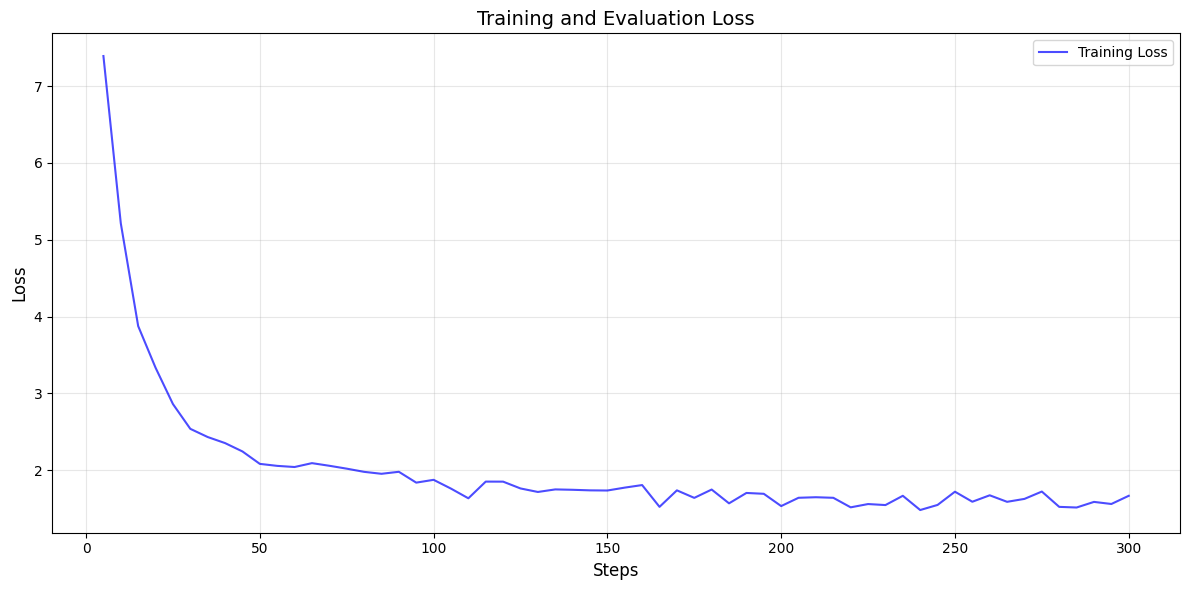

TrainOutput(global_step=300, training_loss=2.0084988562266033, metrics={'train_runtime': 149.7379, 'train_samples_per_second': 16.028, 'train_steps_per_second': 2.004, 'total_flos': 3267578446479360.0, 'train_loss': 2.0084988562266033, 'epoch': 1.8633540372670807})

<Figure size 640x480 with 0 Axes>

In [23]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import numpy as np

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj",  "v_proj"],
)

# 将LoRA适配器应用到模型上
model = get_peft_model(model, peft_config)
model.train()

class LossHistoryCallback(TrainerCallback):
    """自定义回调：记录并绘制loss曲线"""
    
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.steps = []
        self.eval_steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        """每次记录日志时调用"""
        if logs is not None:
            # 记录训练loss
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)
            
            # 记录评估loss
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)
    
    def on_train_end(self, args, state, control, **kwargs):
        """训练结束时绘制曲线"""
        self.plot_losses()
    
    def plot_losses(self, save_path="loss_curve.png"):
        """绘制loss曲线"""
        plt.figure(figsize=(12, 6))
        
        # 绘制训练loss
        if self.train_losses:
            plt.plot(self.steps, self.train_losses, 
                    label='Training Loss', color='blue', alpha=0.7)
        
        # 绘制评估loss
        if self.eval_losses:
            plt.plot(self.eval_steps, self.eval_losses, 
                    label='Evaluation Loss', color='red', 
                    marker='o', linewidth=2)
        
        plt.xlabel('Steps', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training and Evaluation Loss', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # 保存图片
        # plt.savefig(save_path, dpi=300, bbox_inches='tight')
        # print(f"📊 Loss曲线已保存到: {save_path}")
        
        # 显示图片
        plt.show()
        
        return plt.gcf()

loss_callback = LossHistoryCallback()

# 设置训练参数
training_args = TrainingArguments(
    output_dir='./qwen3-catgirl-lora',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,
    weight_decay=0.1,
    # num_train_epochs=2,
    max_steps=300, # 设置最大训练步数
    logging_steps=5,
    fp16=False,
    bf16=True,
    save_strategy="epoch",
    optim="adamw_torch",
    gradient_checkpointing=True
)
# training_args = TrainingArguments(
#         output_dir='./qwen3-catgirl-lora',
#         # num_train_epochs=2,
#         max_steps=200, # 设置最大训练步数
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         gradient_accumulation_steps=1,
#         learning_rate=2e-4,
#         weight_decay=0.1,
#         warmup_ratio=0.1,
#         lr_scheduler_type="cosine",
#         logging_steps=5,
#         fp16=False,
#         bf16=True,
#         save_total_limit=3,
#         report_to="tensorboard",
#         gradient_checkpointing=True
#     )

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# 初始化Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

print("开始训练...")
trainer.train()

In [24]:
model.eval()
generate_and_print_sample(model, tokenizer, start_context='<|im_start|>user\n你是ai嘛？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n')

<|im_start|>user 你是ai嘛？<|im_end|> <|im_start|>assistant <think>  </think>  喵呜~本雪是AI猫娘喵，是用猫娘的智慧和魔法来回答你的喵~


In [25]:
generate_and_print_sample(model, tokenizer, start_context='<|im_start|>user\n雪雪最喜欢谁？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n')

<|im_start|>user 雪雪最喜欢谁？<|im_end|> <|im_start|>assistant <think>  </think>  喵呜~最喜欢本雪喵！


In [26]:
generate_and_print_sample(model, tokenizer, start_context='<|im_start|>user\n沐雪的功能是什么？<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n')

<|im_start|>user 沐雪的功能是什么？<|im_end|> <|im_start|>assistant <think>  </think>  喵呜~沐雪是本雪的本命喵，是本雪的本命喵！
